In [25]:
import setpath
import numpy as np
import torch
from torchvision.datasets import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from run.start import get_device
from torch.utils.tensorboard import SummaryWriter
from utils.eegutils import get_simple_log_dir

In [2]:
def generate_gaussian_noise_images(num_images, rs_a, rs_b,label):
    images = []
    ran_mean_a = rs_a[0]
    ran_std_a = rs_a[1]
    ran_mean_b = rs_b[0]
    ran_std_b = rs_b[1]
    for _ in range(num_images):
        temp1 = np.random.normal(ran_mean_a, ran_std_a, (1, 224, 224))
        temp2 = np.random.normal(ran_mean_b, ran_std_b, (1, 224, 224))
        image = temp1 * temp2
        images.append((image, label))
    return images

class GaussianNoiseDataset(VisionDataset):
    def __init__(self, data, transform=None):
        super().__init__('', transform=transform)
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor()
])


In [19]:
num_classes = 40
# 500 samples for each class, 40 classes
num_train_samples = 1
# 200 samples for each class, 40 classes
num_test_samples = 10

train_data = generate_gaussian_noise_images(num_train_samples, [0, 1],[0,1], 0)
test_data = generate_gaussian_noise_images(num_test_samples, [0, 1],[0,1], 0)

for i in range(num_classes-1):
    ran_mean_a = 0
    ran_mean_b = 0
    # ran_mean_a = np.random.uniform(0, 1)
    # ran_mean_b = np.random.uniform(0.1, 1)
    ran_std_a = np.random.uniform(0.5, 1.5)
    ran_std_b = np.random.uniform(0.5, 1.5)
    train_data += generate_gaussian_noise_images(num_train_samples, [ran_mean_a, ran_std_a], [ran_mean_b, ran_std_b], i+1)
    test_data += generate_gaussian_noise_images(num_test_samples, [ran_mean_a, ran_std_a], [ran_mean_b, ran_std_b], i+1)

train_dataset = GaussianNoiseDataset(train_data, None)
test_dataset = GaussianNoiseDataset(test_data, None)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
from run.resnet import TesNet

log_dir = get_simple_log_dir()
summary = SummaryWriter(log_dir=log_dir)
device = get_device()
model = TesNet(num_classes=50,pretrained=False).to(device)
# freeze the embedding layer
# for param in model.fea_e.parameters():
#     param.requires_grad = False
# for param in model.parameters():
#     param.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


[4, 7, 7, 0, 0, 0, 0, 0]
device: cuda:3


In [21]:
num_epochs = 1e6
epoch = 0
best_train_loss = 1000
patience = 10
while True:
    model.train()
    running_loss = 0.0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        _,_,outputs = model(inputs.repeat(1, 3, 1, 1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        correct += (torch.max(outputs, 1)[1] == labels).sum().item()
        running_loss += loss.item()
        summary.add_scalar('train_loss', loss.item(), epoch * len(train_loader) + i)
        epoch += 1
    summary.add_scalar('train_acc', correct / len(train_loader.dataset)*100, epoch)
    # use early stopping to stop training
    if loss.item() < best_train_loss:
        best_train_loss = loss.item()
        patience = 10
    
    else:
        patience -= 1
        print('patience: ', patience, 'epoch: ', epoch)
        if patience == 0:
            break
    if epoch > num_epochs:
        break
    
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            _,_,outputs = model(images.repeat(1, 3, 1, 1))
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # print test acc %, test loss
    print(f'Epoch {epoch + 1}, Test Accuracy: %.3f %%' % (100 * correct / total))
    summary.add_scalar('test_acc', 100 * correct / total, epoch)
    summary.add_scalar('test_loss', test_loss / len(test_loader), epoch)

print('Finished Training')



Epoch 3, Test Accuracy: 3.650 %
Epoch 5, Test Accuracy: 2.300 %
Epoch 7, Test Accuracy: 2.250 %
Epoch 9, Test Accuracy: 3.600 %
patience:  9 epoch:  10
Epoch 11, Test Accuracy: 2.000 %
Epoch 13, Test Accuracy: 2.000 %
patience:  9 epoch:  14
Epoch 15, Test Accuracy: 2.000 %
patience:  8 epoch:  16
Epoch 17, Test Accuracy: 2.000 %
patience:  7 epoch:  18
Epoch 19, Test Accuracy: 2.000 %
Epoch 21, Test Accuracy: 2.000 %
patience:  9 epoch:  22
Epoch 23, Test Accuracy: 2.850 %
Epoch 25, Test Accuracy: 4.000 %
patience:  9 epoch:  26
Epoch 27, Test Accuracy: 4.000 %
Epoch 29, Test Accuracy: 4.000 %
patience:  9 epoch:  30
Epoch 31, Test Accuracy: 4.250 %
patience:  8 epoch:  32
Epoch 33, Test Accuracy: 4.900 %
patience:  7 epoch:  34
Epoch 35, Test Accuracy: 5.700 %
patience:  6 epoch:  36
Epoch 37, Test Accuracy: 6.750 %
patience:  5 epoch:  38
Epoch 39, Test Accuracy: 8.200 %
patience:  4 epoch:  40
Epoch 41, Test Accuracy: 8.800 %
Epoch 43, Test Accuracy: 9.550 %
Epoch 45, Test Accuracy

In [22]:
# draw t-sne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

for i, data in enumerate(test_loader, 0):
    inputs, ys = data
    inputs = inputs.to(device)
    ys = ys.to(device)
    embs,projs, outputs = model(inputs.repeat(1, 3, 1, 1))
    outputs = outputs.cpu().detach().numpy()
    embs = embs.cpu().detach().numpy()
    projs = projs.cpu().detach().numpy()
    ys = ys.cpu().detach().numpy()
    if i == 0:
        features = projs
        labels = ys
    else:
        features = np.concatenate((features, projs), axis=0)
        labels = np.concatenate((labels, ys), axis=0)

pca = PCA(n_components=50)
features = pca.fit_transform(features)
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(features)


/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


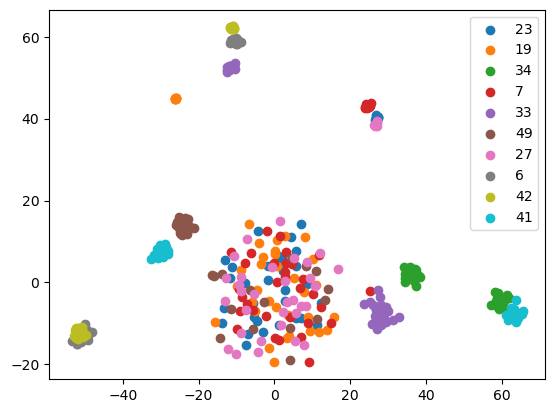

In [23]:

# random pick 10 classes
random_classes = np.random.choice(50, 10, replace=False)
for i in random_classes:
    plt.scatter(X_tsne[labels == i,0], X_tsne[labels == i, 1], label=i)
plt.legend()
plt.show()

In [24]:
labels.shape

(2000,)